# FWI modelo personalizado

In [1]:
using PyPlot, JLD, SegyIO, JUDI, SlimOptim, Statistics, Random, LinearAlgebra, ImageFiltering, Dates, DelimitedFiles

┌ Info: Initializing openacc/openmp offloading
└ @ JUDI /home/geopc3/.julia/packages/JUDI/DUfUj/src/JUDI.jl:123


In [2]:
M = load("model_custom_fwi_result_low_f.jld");

In [3]:
model = Model(M["n"], M["d"], M["o"], M["m"])
model0 = Model(M["n"], M["d"], M["o"], M["m0"])
dm = vec(M["dm"]);

In [4]:
vmin = ones(Float32,model0.n) .* 1.5f0
vmax = ones(Float32,model0.n) .* 3.0f0;
mmin = vec((1f0 ./ vmax).^2)
mmax = vec((1f0 ./ vmin).^2);

In [5]:
block = segy_read("model_custom_high_f.segy")
d_obs = judiVector(block);

┌ Warning: Fixed length trace flag set in stream: IOBuffer(data=UInt8[...], readable=true, writable=false, seekable=true, append=false, size=4763124, maxsize=Inf, ptr=3601, mark=-1)
└ @ SegyIO /home/geopc3/.julia/packages/SegyIO/aQwou/src/read/read_file.jl:36


In [6]:
# Set up wavelet
srcGeometry = Geometry(block; key="source")	# read source position geometry
wavelet = ricker_wavelet(srcGeometry.t[1], srcGeometry.dt[1], 0.015f0)	# 4 Hz wavelet
q = judiVector(srcGeometry, wavelet)

judiVector{Float32, Matrix{Float32}} with 21 sources


In [7]:
F0 = judiModeling(deepcopy(model0), srcGeometry, d_obs.geometry)

JUDI forward{Float32} propagator (src * rec * time) -> (src * rec * time)


In [8]:
# Optimization parameters
niterations = parse(Int, get(ENV, "NITER", "30"))
batchsize = 16
fhistory_SGD = zeros(Float32, niterations);
m0_values = zeros(length(model0.m), niterations);

In [9]:
# Projection operator for bound constraints
proj(x) = reshape(median([vec(mmin) vec(x) vec(mmax)]; dims=2),model0.n)
ls = BackTracking(order=3, iterations=10, );

In [10]:
# Main loop
t1 = now();
for j=1:niterations

    # get fwi objective function value and gradient
    i = randperm(d_obs.nsrc)[1:batchsize]
    fval, gradient = fwi_objective(model0, q[i], d_obs[i])
    p = -gradient/norm(gradient, Inf)
    
    println("FWI iteration no: ",j,"; function value: ",fval)
    fhistory_SGD[j] = fval

    # linesearch
    function ϕ(α)
        F0.model.m .= proj(model0.m .+ α * p)
        misfit = .5*norm(F0[i]*q[i] - d_obs[i])^2
        @show α, misfit
        return misfit
    end
    step, fval = ls(ϕ, 1f-1, fval, dot(gradient, p))

    # Update model and bound projection
    model0.m .= proj(model0.m .+ step .* p)
    m0_values[:, j] = model0.m
end
t2 = now();

Building forward operator
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] a

FWI iteration no: 1; function value: 6344.089
(α, misfit) = 

(0.1f0, 5889.142578125)


Building forward operator
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.13 s
Operator `forward` ran in 0.11 s
Operator `forward` ran in 0.11 s
Operator `forward` ran in 0.13 s
Operator `forward` ran in 0.11 s
Operator `forward` ran in 0.11 s
Operator `forward` ran in 0.13 s
Operator `forward` ran in 0.12 s
Operator `forward` ran in 0.12 s
Operator `forward` ran in 0.11 s
Operator `forward` ran in 0.11 s
Operator `forward` ran in 0.11 s
Operator `forward` ran in 0.11 s
Operator `forward` ran in 0.11 s
Operator `forward` ran in 0.12 s


FWI iteration no: 2; function value: 5454.4053
(α, misfit) = 

Operator `forward` ran in 0.13 s
Operator `gradient` ran in 0.12 s
Operator `forward` ran in 0.13 s
Operator `gradient` ran in 0.12 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.19 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.19 s
Operator `forward` ran in 0.22 s
Operator `gradient` ran in 0.22 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.

(0.1f0, 5994.33740234375)


Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.12 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.13 s
Operator `forward` ran in 0.19 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.19 s
Operator `forward` ran in 0.17 s


(α, misfit) = (0.04919037275322525, 1527.7108154296875)
FWI iteration no: 

Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s


3; function value: 1561.801


Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 36057.1484375)
(α, misfit) = 

Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s


(0.01668320940919579, 1678.0418701171875)


Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s


(α, misfit) = (0.0077748239724358915, 977.2906494140625)
FWI iteration no: 

Operator `forward` ran in 0.19 s
Operator `forward` ran in 0.19 s
Operator `forward` ran in 0.19 s
Operator `forward` ran in 0.19 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s


4; function value: 1072.0917


Operator `forward` ran in 0.25 s
Operator `gradient` ran in 0.23 s
Operator `forward` ran in 0.24 s
Operator `gradient` ran in 0.21 s
Operator `forward` ran in 0.22 s
Operator `gradient` ran in 0.18 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.22 s
Operator `gradient` ran in 0.18 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.22 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 16123.310546875)
(α, misfit) = 

Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s


(0.018627940807842778, 923.4393310546875)


Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.20 s


FWI iteration no: 5; function value: 887.21344
(α, misfit) = 

Operator `forward` ran in 0.25 s
Operator `gradient` ran in 0.21 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.20 s
Operator `forward` ran in 0.21 s
Operator `gradient` ran in 0.18 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.21 s
Operator `gradient` ran in 0.19 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.20 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.

(0.1f0, 37551.5546875)


Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s


(α, misfit) = (0.013346033645187334, 1197.401611328125)
(α, misfit) = 

Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.19 s
Operator `forward` ran in 0.18 s


(0.005497765896222432, 598.3018798828125)


Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.19 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s


FWI iteration no: 6; function value: 531.9867
(α, misfit) = 

Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.

(0.1f0, 2422.0146484375)


Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s


(α, misfit) = (0.04237186602854784, 574.9049682617188)
(α, misfit) = 

Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s


(0.018629144876712748, 389.7643127441406)


Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s


FWI iteration no: 7; function value: 433.48676
(α, misfit) = 

Operator `forward` ran in 0.19 s
Operator `gradient` ran in 0.18 s
Operator `forward` ran in 0.19 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.

(0.1f0, 335343.8125)


Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s


(α, misfit) = (0.010000000149011612, 4539.4169921875)
(α, misfit) = 

Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s


(0.0010000000149011613, 416.37054443359375)


Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s


FWI iteration no: 8; function value: 457.14362
(α, misfit) = 

Operator `forward` ran in 0.19 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.19 s
Operator `gradient` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.

(0.1f0, 2611.06591796875)


Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.19 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.16 s


(α, misfit) = (0.039657109345084825, 689.2083129882812)
(α, misfit) = 

Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.16 s


(0.01632913416327203, 408.3385314941406)


Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s


FWI iteration no: 9; function value: 406.6757
(α, misfit) = 

Operator `forward` ran in 0.20 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.

(0.1f0, 339946.53125)


Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s


(α, misfit) = (0.010000000149011612, 6968.14208984375)
(α, misfit) = 

Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s


(0.0010000000149011613, 380.6492004394531)


Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.13 s
Operator `forward` ran in 0.12 s


FWI iteration no: 10; function value: 362.72394
(α, misfit) = 

Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.

(0.1f0, 5728.78271484375)


Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.16 s


(α, misfit) = (0.029224930262235018, 651.8572387695312)
(α, misfit) = 

Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s


(0.011849606171235335, 330.5725402832031)


Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s


FWI iteration no: 11; function value: 301.0925
(α, misfit) = 

Operator `forward` ran in 0.19 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.

(0.1f0, 331799.875)


Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s


(α, misfit) = (0.010000000149011612, 4988.5)
(α, misfit) = 

Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s


(0.0010000000149011613, 282.6294860839844)


Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s


FWI iteration no: 12; function value: 311.31003
(α, misfit) = 

Operator `forward` ran in 0.19 s
Operator `gradient` ran in 0.18 s
Operator `forward` ran in 0.19 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.18 s
Operator `forward` ran in 0.19 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.

(0.1f0, 1937.5732421875)


Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s


(α, misfit) = (0.04108440157650479, 631.7017822265625)
(α, misfit) = 

Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s


(0.01607225580784327, 320.9542236328125)


Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s


(α, misfit) = (0.007091625490386382, 281.22247314453125)
FWI iteration no: 

Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.16 s


13; function value: 254.30368


Operator `forward` ran in 0.19 s
Operator `gradient` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.18 s
Operator `forward` ran in 0.19 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.20 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 391837.1875)
(α, misfit) = 

Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s


(0.010000000149011612, 7117.50048828125)


Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s


(α, misfit) = (0.0010000000149011613, 273.4191589355469)
(α, misfit) = 

Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s


(0.00037207416924358374, 243.52256774902344)


Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s


FWI iteration no: 14; function value: 258.47433
(α, misfit) = 

Operator `forward` ran in 0.19 s
Operator `gradient` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.

(0.1f0, 41324.6875)


Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s


(α, misfit) = (0.010000000149011612, 678.7847900390625)
(α, misfit) = 

Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s


(0.0019615129865124367, 248.2328338623047)


Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s


FWI iteration no: 15; function value: 231.68063
(α, misfit) = 

Operator `forward` ran in 0.19 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.

(0.1f0, 309495.21875)


Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.19 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s


(α, misfit) = (0.010000000149011612, 6606.2177734375)
(α, misfit) = 

Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s


(0.0010000000149011613, 265.1451416015625)


Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s


(α, misfit) = (0.0003013255491820962, 225.16587829589844)
FWI iteration no: 

Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s


16; function value: 236.60822


Operator `forward` ran in 0.19 s
Operator `gradient` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 8849.576171875)
(α, misfit) = 

Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s


(0.014991500429740507, 634.4618530273438)


Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s


(α, misfit) = (0.004057702846776451, 249.42779541015625)
(α, misfit) = 

Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s


(0.0017369723330436038, 227.6676025390625)


Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.16 s


FWI iteration no: 17; function value: 209.26048
(α, misfit) = 

Operator `forward` ran in 0.19 s
Operator `gradient` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.19 s
Operator `gradient` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.

(0.1f0, 345627.375)


Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s


(α, misfit) = (0.010000000149011612, 6329.10498046875)
(α, misfit) = 

Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.19 s


(0.0010000000149011613, 236.3076934814453)


Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s


(α, misfit) = (0.0002989955215525389, 203.2026824951172)
FWI iteration no: 

Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s


18; function value: 223.27698


Operator `forward` ran in 0.19 s
Operator `gradient` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 26948.966796875)
(α, misfit) = 

Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s


(0.010000000149011612, 471.0252380371094)


Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s


(α, misfit) = (0.0023421389258834516, 216.55690002441406)
FWI iteration no: 

Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s


19; function value: 218.94371


Operator `forward` ran in 0.19 s
Operator `gradient` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 283988.84375)
(α, misfit) = 

Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.19 s
Operator `forward` ran in 0.18 s


(0.010000000149011612, 5039.7529296875)


Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s


(α, misfit) = (0.0010000000149011613, 237.17669677734375)
(α, misfit) = 

Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.16 s


(0.0003632393315468059, 211.55035400390625)


Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.16 s


FWI iteration no: 20; function value: 215.77525
(α, misfit) = 

Operator `forward` ran in 0.19 s
Operator `gradient` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.

(0.1f0, 10195.275390625)


Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s


(α, misfit) = (0.01370947269020811, 576.248046875)
(α, misfit) = 

Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s


(0.003789623349034247, 222.8804168701172)


Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s


(α, misfit) = (0.001686596570798411, 206.17962646484375)
FWI iteration no: 

Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s


21; function value: 221.88715


Operator `forward` ran in 0.19 s
Operator `gradient` ran in 0.18 s
Operator `forward` ran in 0.19 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 326107.4375)
(α, misfit) = 

Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s


(0.010000000149011612, 5998.548828125)


Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s


(α, misfit) = (0.0010000000149011613, 254.77804565429688)
(α, misfit) = 

Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s


(0.00024119298841275075, 218.243896484375)


Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s


FWI iteration no: 22; function value: 191.39272
(α, misfit) = 

Operator `forward` ran in 0.19 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.

(0.1f0, 29754.193359375)


Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s


(α, misfit) = (0.010000000149011612, 490.8410949707031)
(α, misfit) = 

Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.16 s


(0.0018978633553508341, 185.51954650878906)


Operator `forward` ran in 0.19 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s


FWI iteration no: 23; function value: 219.12384
(α, misfit) = 

Operator `forward` ran in 0.19 s
Operator `gradient` ran in 0.19 s
Operator `forward` ran in 0.20 s
Operator `gradient` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.

(0.1f0, 191803.25)


Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s


(α, misfit) = (0.010000000149011612, 3037.78466796875)
(α, misfit) = 

Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s


(0.0010000000149011613, 220.68328857421875)


Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s


(α, misfit) = (0.00047888067322064215, 210.2223358154297)
FWI iteration no: 

Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s


24; function value: 188.58293


Operator `forward` ran in 0.19 s
Operator `gradient` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 3063.413330078125)
(α, misfit) = 

Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s


(0.024956427107486634, 439.7421569824219)


Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s


(α, misfit) = (0.008362883930493947, 196.0151824951172)
(α, misfit) = 

Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s


(0.0037042811770906315, 178.4792022705078)


Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.16 s


FWI iteration no: 25; function value: 194.87894
(α, misfit) = 

Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.

(0.1f0, 361201.125)


Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s


(α, misfit) = (0.010000000149011612, 6948.39013671875)
(α, misfit) = 

Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s


(0.0010000000149011613, 233.6119384765625)


Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s


(α, misfit) = (0.0002369939348289698, 190.72357177734375)
FWI iteration no: 

Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s


26; function value: 198.50739


Operator `forward` ran in 0.19 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 37538.32421875)
(α, misfit) = 

Operator `forward` ran in 0.13 s
Operator `forward` ran in 0.13 s
Operator `forward` ran in 0.12 s
Operator `forward` ran in 0.12 s
Operator `forward` ran in 0.12 s
Operator `forward` ran in 0.12 s
Operator `forward` ran in 0.13 s
Operator `forward` ran in 0.13 s
Operator `forward` ran in 0.12 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s


(0.010000000149011612, 718.557861328125)


Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s


(α, misfit) = (0.0014564154979746359, 192.47293090820312)
FWI iteration no: 

Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s


27; function value: 192.82176


Operator `forward` ran in 0.19 s
Operator `gradient` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 224426.15625)
(α, misfit) = 

Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s


(0.010000000149011612, 3655.595947265625)


Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s


(α, misfit) = (0.0010000000149011613, 205.24002075195312)
(α, misfit) = 

Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s


(0.0003774286323008136, 186.7032470703125)


Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.19 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s


FWI iteration no: 28; function value: 158.03131
(α, misfit) = 

Operator `forward` ran in 0.19 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.

(0.1f0, 1837.3255615234375)


Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s


(α, misfit) = (0.028773149572932522, 308.9466247558594)
(α, misfit) = 

Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s


(0.010554015047118285, 161.56759643554688)


Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s


(α, misfit) = (0.0046983956227673465, 149.41554260253906)
FWI iteration no: 

Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.14 s
Operator `forward` ran in 0.12 s


29; function value: 177.49098


Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 363829.1875)
(α, misfit) = 

Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s


(0.010000000149011612, 7714.97265625)


Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s


(α, misfit) = (0.0010000000149011613, 221.39306640625)
(α, misfit) = 

Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s


(0.00023628062988283668, 172.8582305908203)


Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s


FWI iteration no: 30; function value: 161.64655
(α, misfit) = 

Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.18 s
Operator `forward` ran in 0.19 s
Operator `gradient` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.

(0.1f0, 25829.740234375)


Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s


(α, misfit) = (0.010000000149011612, 440.0798034667969)
(α, misfit) = 

Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s


(0.001973742329598996, 156.408203125)


Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `forward` ran in 0.18 s


In [11]:
fwi = sqrt.(1f0./adjoint(model0.m)).data;
v0 = sqrt.(1f0./M["m0"])';
v = sqrt.(1f0./model.m)'.data;

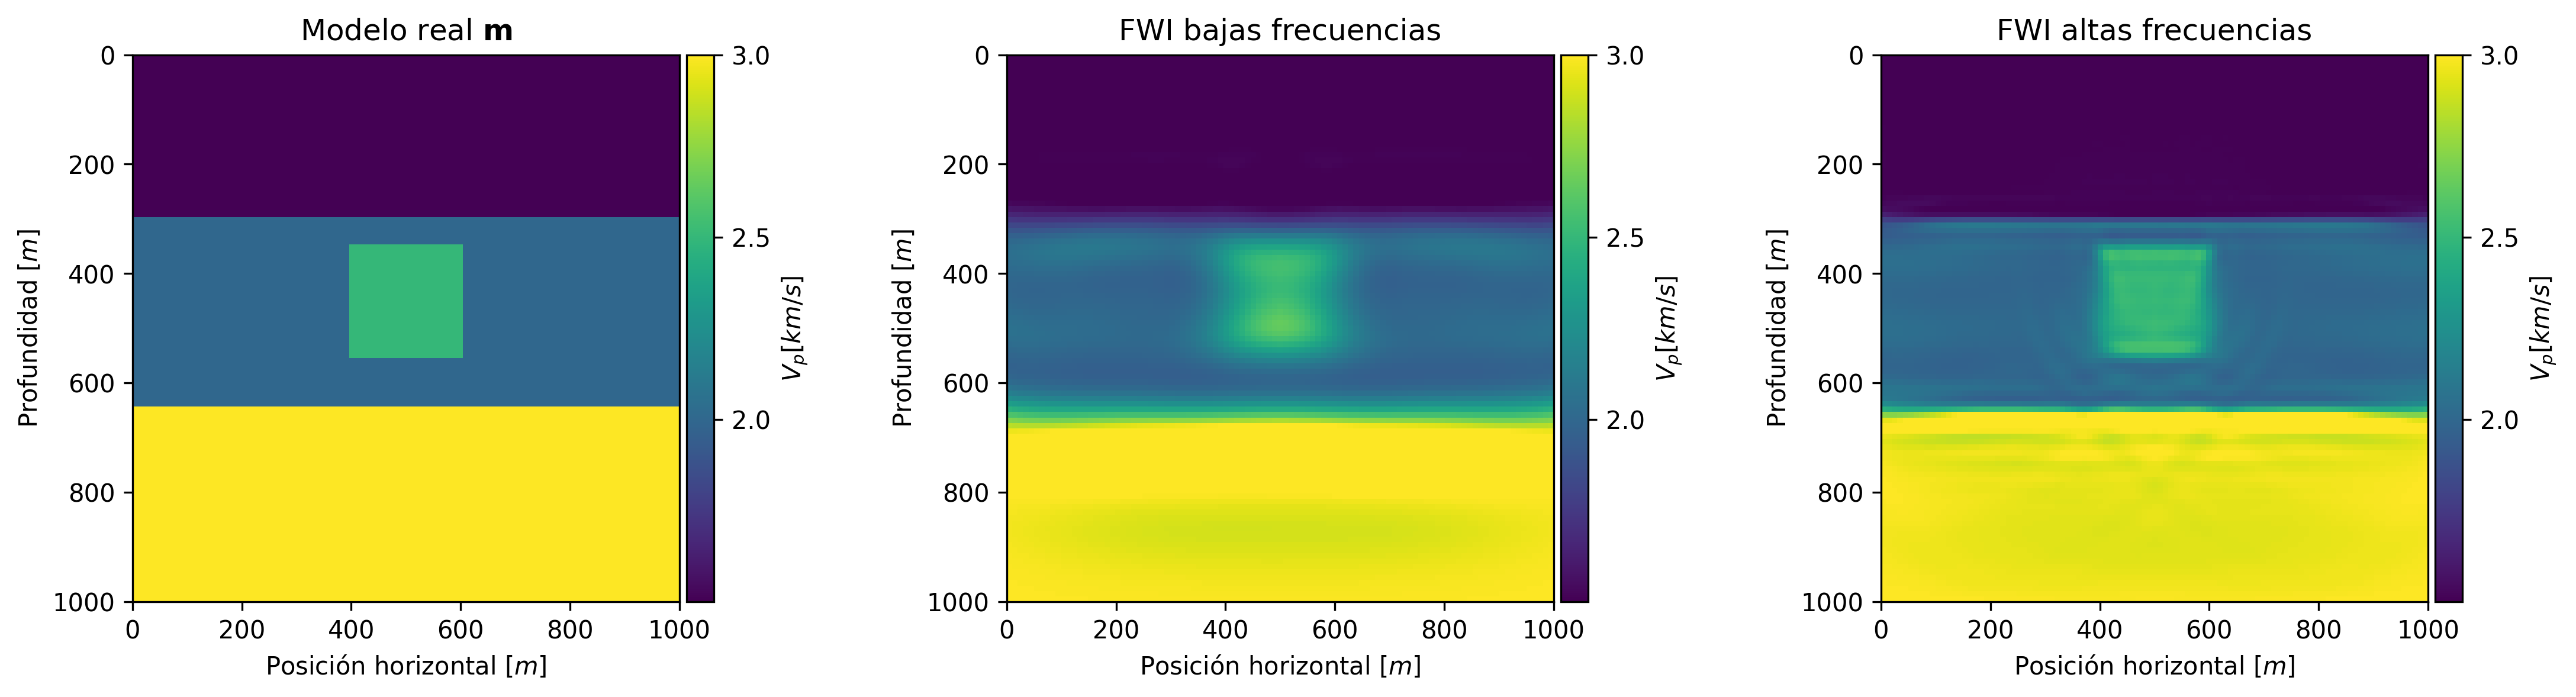

In [12]:
fig=figure(figsize=(18,4), dpi=300);
subplot(131)
im = imshow(v, cmap="viridis", extent=[0, (model.n[1]-1)*model.d[1], (model.n[2]-1)*model.d[2], 0], vmin=1.5, vmax=3.0)
cb = colorbar(im, ticks=unique(v), pad=0.01)
cb[:set_label](label = L"$V_p [km/s]$")
xlabel(L"Posición horizontal $[m]$")
ylabel(L"Profundidad $[m]$")
title(L"Modelo real $\mathbf{m}$")
subplot(132)
im = imshow(v0, cmap="viridis", extent=[0, (model.n[1]-1)*model.d[1], (model.n[2]-1)*model.d[2], 0], vmin=1.5, vmax=3.0)
cb = colorbar(im, ticks=unique(v), pad=0.01)
cb[:set_label](label = L"$V_p [km/s]$")
xlabel(L"Posición horizontal $[m]$")
ylabel(L"Profundidad $[m]$")
title("FWI bajas frecuencias")
subplot(133)
im = imshow(fwi, cmap="viridis", extent=[0, (model.n[1]-1)*model.d[1], (model.n[2]-1)*model.d[2], 0], vmin=1.5, vmax=3.0)
cb = colorbar(im, ticks=unique(v), pad=0.01)
cb[:set_label](label = L"$V_p [km/s]$")
xlabel(L"Posición horizontal $[m]$")
ylabel(L"Profundidad $[m]$")
title("FWI altas frecuencias")
display(fig)

In [13]:
mse = sum((v .- v0).^2) / length(v)
println("El error cuadrático medio del modelo inicial es: ", mse)
mse = sum((v .- fwi).^2) / length(v)
println("El error cuadrático medio de FWI es: ", mse)

El error cuadrático medio del modelo inicial es: 0.010780065
El error cuadrático medio de FWI es: 0.0052191466


In [14]:
error_porcentaje_v0 = 100 * sum(abs.(v - v0)) / sum(abs.(v))
error_porcentaje_fwi = 100 * sum(abs.(v - fwi)) / sum(abs.(v))

println("Porcentaje de error (v0): ", error_porcentaje_v0)
println("Porcentaje de error (FWI): ", error_porcentaje_fwi)

Porcentaje de error (v0): 2.1862326
Porcentaje de error (FWI): 1.5721104


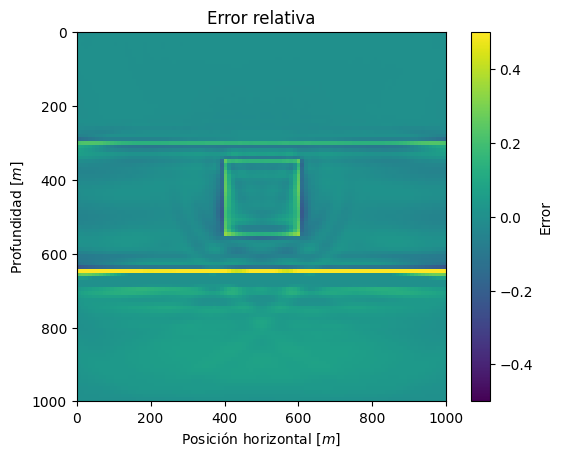

In [15]:
difs = v-fwi
fig=figure() #figsize=(20, 5)
im = imshow(difs, cmap="viridis", extent=[0, (model.n[1]-1)*model.d[1], (model.n[2]-1)*model.d[2], 0], vmin=-0.5, vmax=0.5)
cb = colorbar(im)
cb[:set_label](label = "Error")
xlabel(L"Posición horizontal $[m]$")
ylabel(L"Profundidad $[m]$")
title("Error relativa")
display(fig)

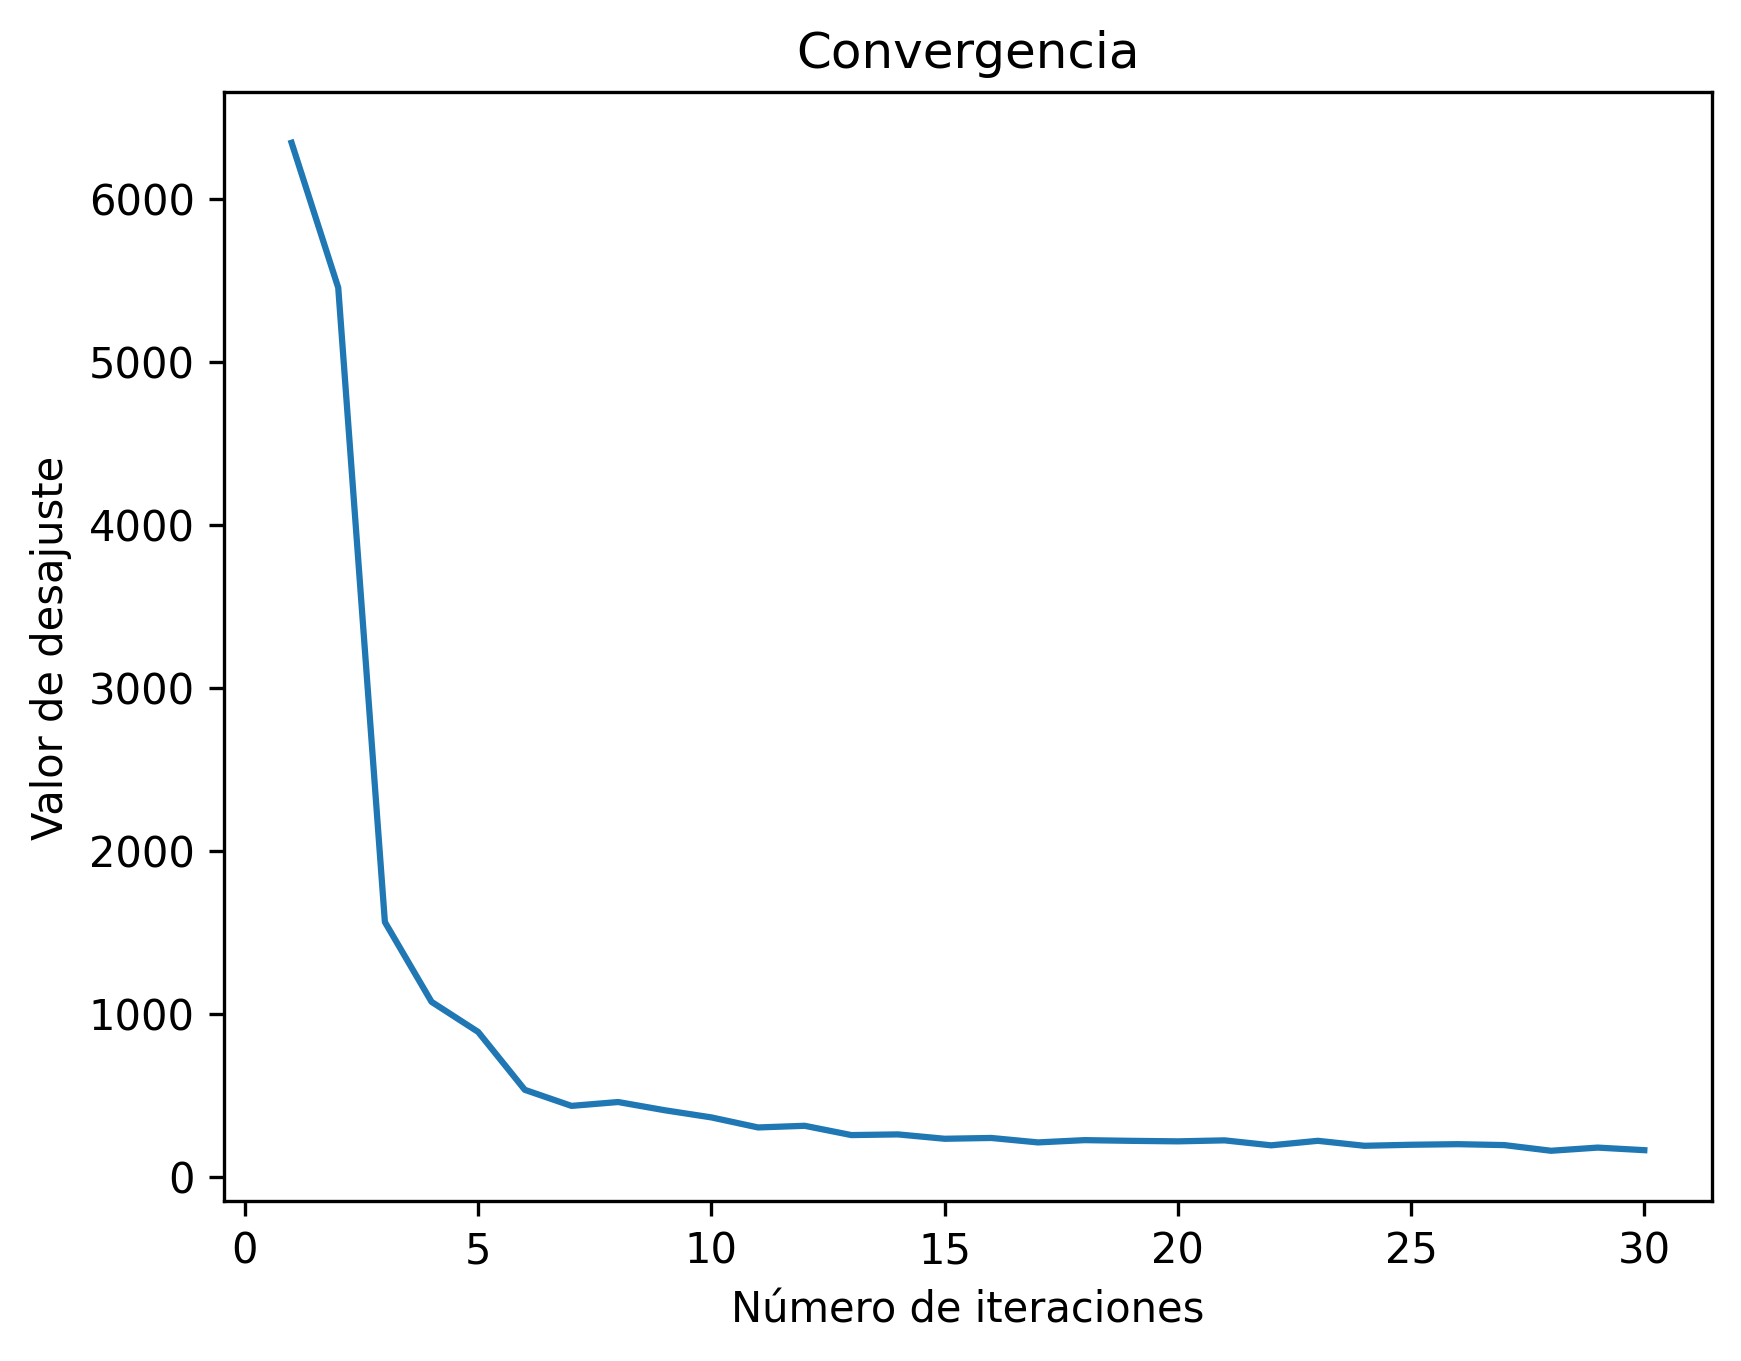

In [16]:
fig=figure(dpi=300) #figsize=(20, 5)
xax = 1:1:30
plot(xax, fhistory_SGD)
xlabel("Número de iteraciones")
ylabel("Valor de desajuste")
title("Convergencia")
display(fig)

In [17]:
save("model_custom_fwi_result_high_f.jld", "n", M["n"], "d", M["d"], "o", M["o"], "m", M["m"], "m0", model0.m.data, "dm", dm)

In [18]:
m_real = imfilter(v, Kernel.gaussian((7,7)));

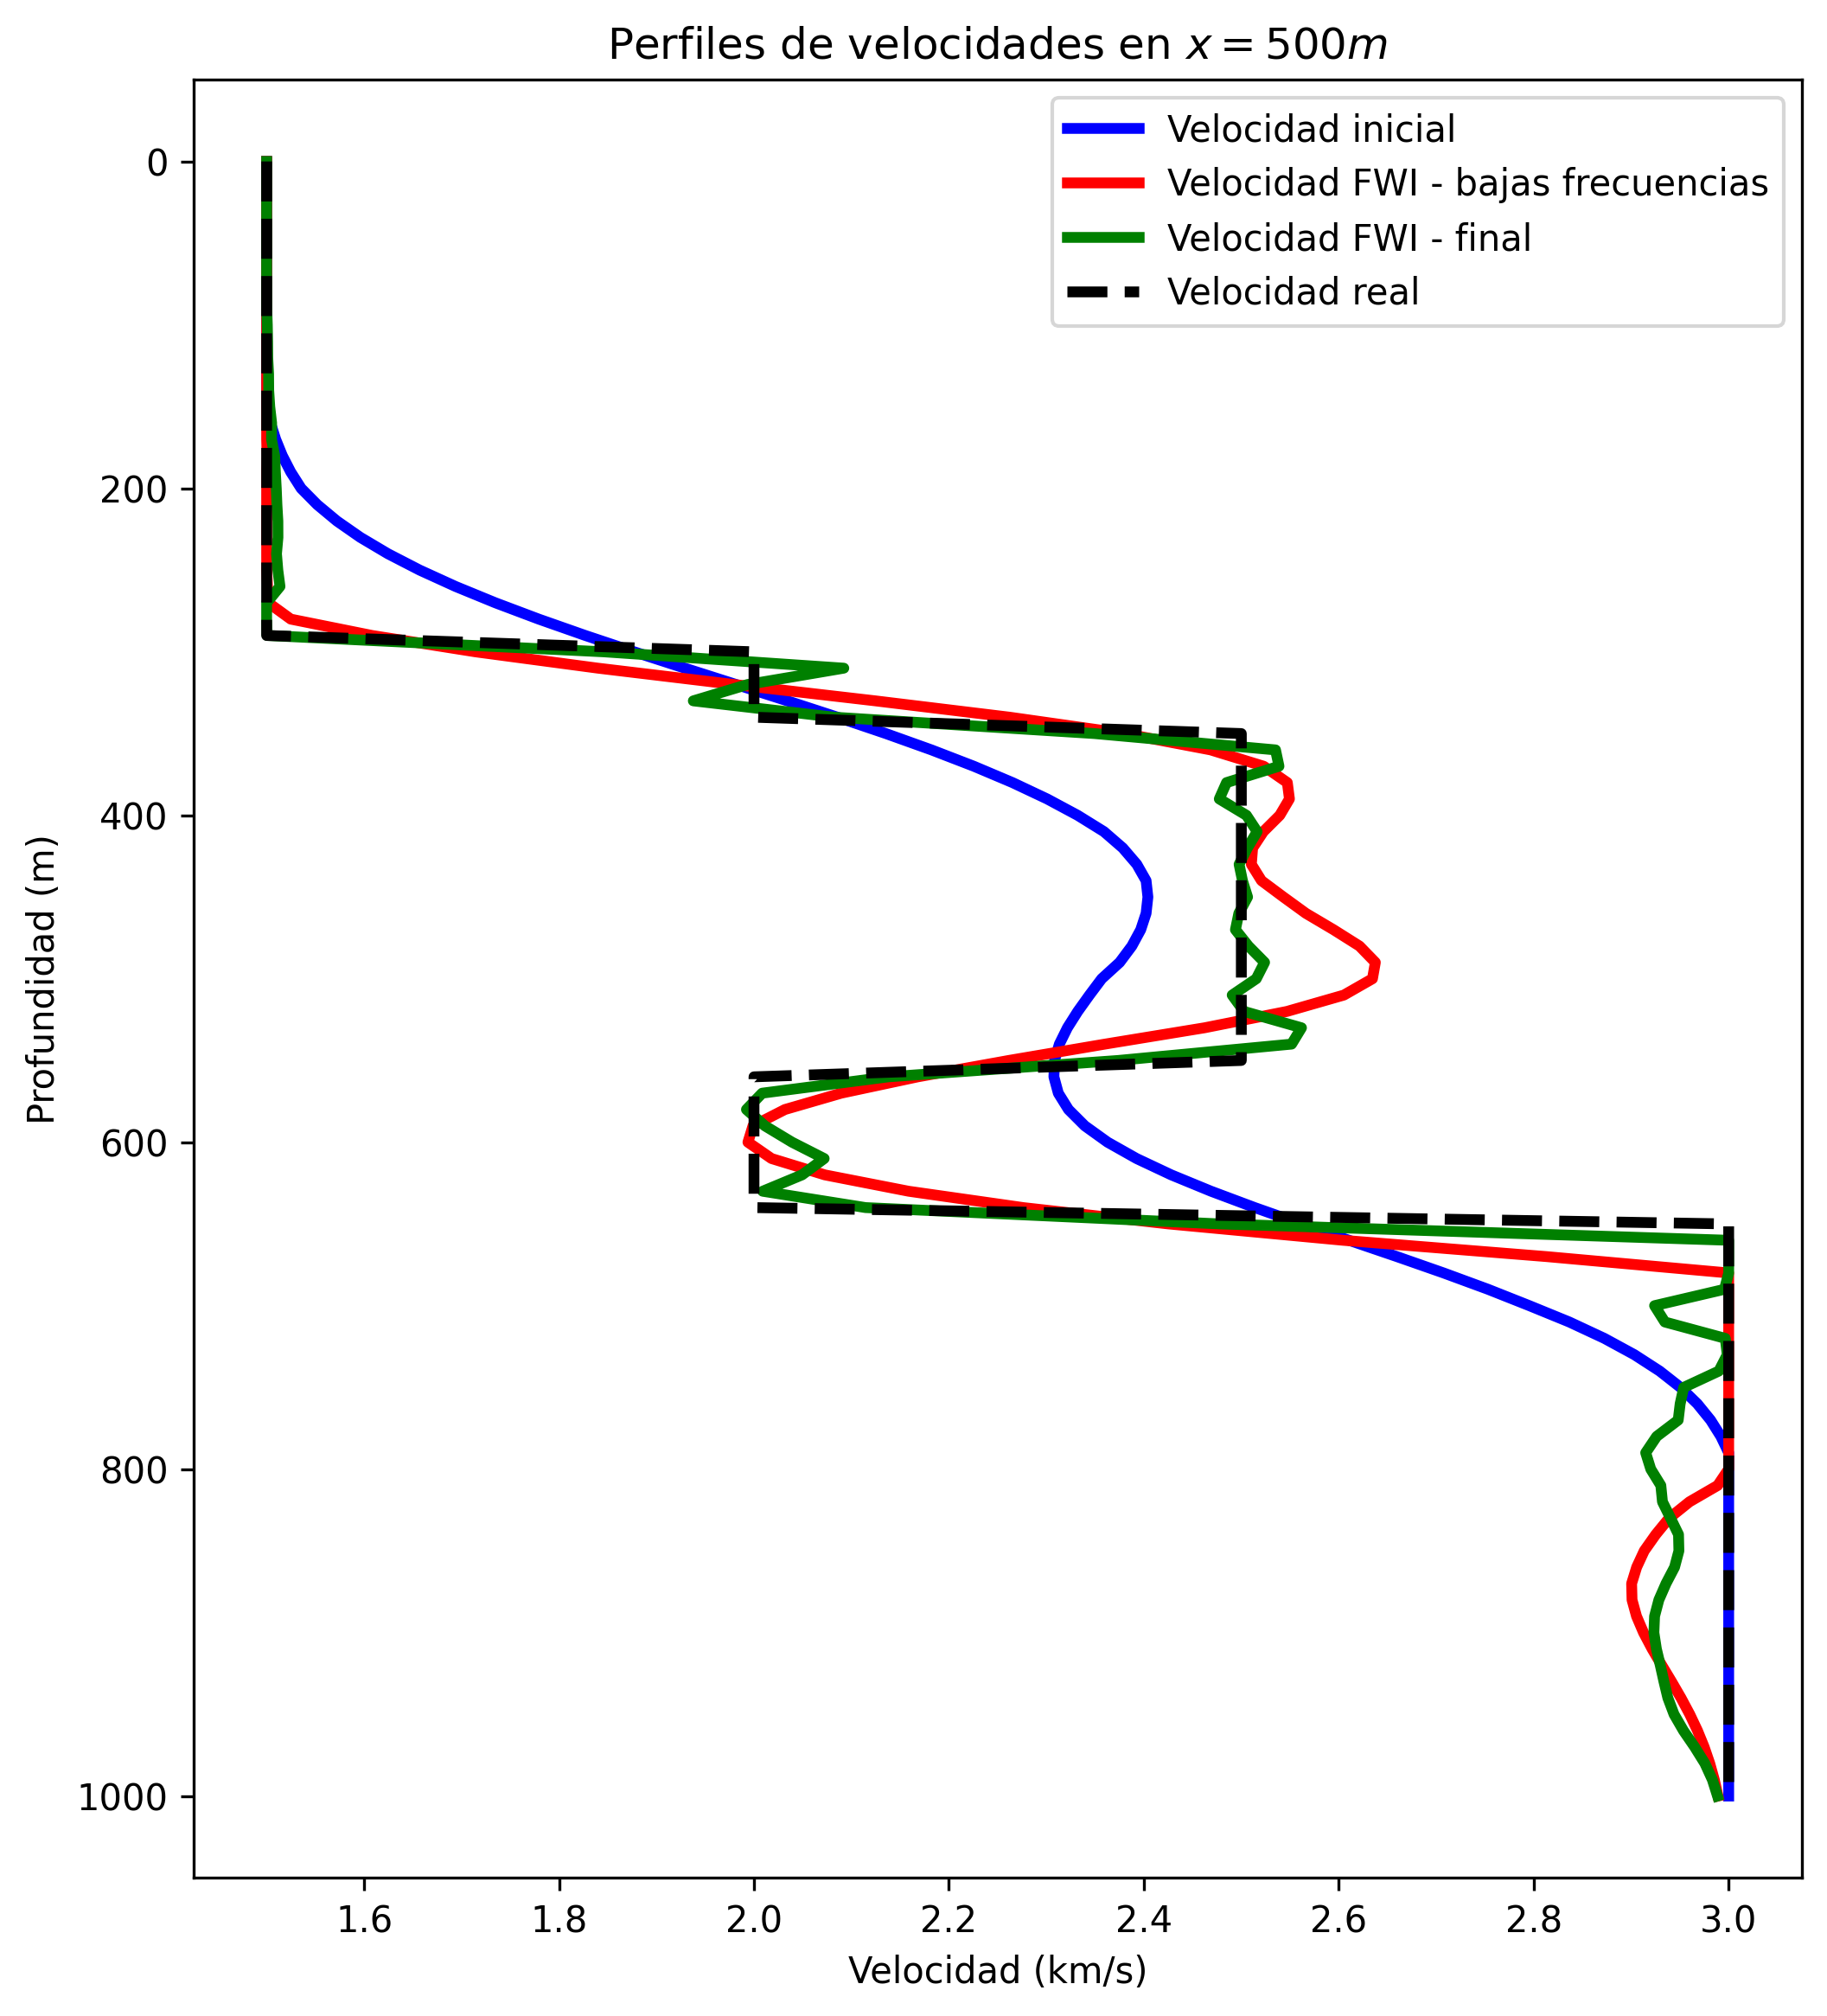

In [19]:
fig = figure(figsize=(8,9), dpi=300)
xax = range(0, stop=1000, step=10)
plot(m_real[:,50], xax, linewidth=3, label="Velocidad inicial", "b")
plot(v0[:,50], xax, linewidth=3, label="Velocidad FWI - bajas frecuencias", "r")
plot(fwi[:,50], xax, linewidth=3, label="Velocidad FWI - final", "g")
plot(v[:,50], xax, linewidth=3, label="Velocidad real", "k--")
legend()
gca().invert_yaxis()
ylabel("Profundidad (m)")
xlabel("Velocidad (km/s)")
title(L"Perfiles de velocidades en $x=500m$")
display(fig)

In [20]:
writedlm("fwi_h_results/m0.txt", v0)
writedlm("fwi_h_results/fwi.txt", m0_values)
writedlm("fwi_h_results/mtrue.txt", v)
writedlm("fwi_h_results/fval.txt", fhistory_SGD)

In [21]:
canonicalize(t2 - t1)

8 minutes, 20 seconds, 96 milliseconds

In [23]:
t2-t1

500096 milliseconds